# Overview
In order to choose a small number of representative strains for the gut microbiome, cluster models based on comsumed and excreted metabolites.

In [132]:
# -*- coding:utf-8 -*-
import sys, os
import cobra
import glob
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
print("python version: " + sys.version)
print("cobra version: " + cobra.__version__)
print("pandas version: " + pd.__version__)
print("seaborn version: " + sns.__version__)

python version: 2.7.14 (default, Sep 23 2017, 22:06:14) 
[GCC 7.2.0]
cobra version: 0.11.2
pandas version: 0.22.0
seaborn version: 0.8.1


In [94]:
out_dir = "agora-1_02"
metabolites_file = "%s/metabolites.tsv" % (out_dir)
species_metabolites_fluxes_file = "%s/species_io_fluxes.tsv" % (out_dir)

In [95]:
# read the species-metabolite flux values from the file
species_io_met = defaultdict(dict)
with open(species_metabolites_fluxes_file, 'r') as f:
    metabolites = f.readline().rstrip().split('\t')[1:]
    # make them all lower case
    metabolites = [m.lower() for m in metabolites]
    for line in f:
        line = line.rstrip().split('\t')
        s = line[0]
        # strip extra underscores
        s = s.strip('_')
        fluxes = line[1:]
        for i in range(1,len(metabolites)):
            if fluxes[i] != "NA":
                species_io_met[s][metabolites[i]] = float(fluxes[i])
            
print("%d species, %d metabolites" % (len(species_io_met), len(metabolites)))

818 species, 450 metabolites


In [96]:
# get the in and out metabolites for each species
# TODO summarize the metabolites at the genus level

# do the out-fluxes first, then the in-fluxes
species_in_met = defaultdict(set)
species_out_met = defaultdict(set)
for s in species_io_met:
    for m in species_io_met[s]:
        # if this is an outgoing flux (i.e., into the extracellular space out of the cell):
        if species_io_met[s][m] >= 0:
            species_in_met[s].add(m)
        elif species_io_met[s][m] <= 0:
            species_out_met[s].add(m)
            
print("%d species with in-metabolites, %d with out" % (len(species_in_met), len(species_out_met)))
in_met_count = len(set(m for met_set in species_in_met.values() for m in met_set))
out_met_count = len(set(m for met_set in species_out_met.values() for m in met_set))
print("%d in-metabolites, %d out-metabolites" % (in_met_count, out_met_count))

818 species with in-metabolites, 818 with out
447 in-metabolites, 233 out-metabolites


In [97]:
def compute_jaccard_and_cluster(met_prots, output_prefix, method="average", ordering=None, forced=False):
    #out_file = "%sjaccard-indeces.txt" % (output_prefix)
    out_file = "%sjaccard-clustered.txt" % (output_prefix)
    if forced or not os.path.isfile(out_file):
        print("Computing overlap using '%s' method" % (method))
        # first compute the jaccard index of every met pair 
        # then write the overlap of the hits (rec and TF) and take some sort of ratio
        # dictionary of metA-metB pairs as the keys and the jaccard index as the overlap
        overlaps = {metA: {} for metA in met_prots}
        for metA in met_prots:
            for metB in met_prots:
                # create a symmetrical matrix of the overlaps so that they can be clustered correctly
                if metA < metB:
                    metA_prots = set(met_prots[metA])
                    metB_prots = set(met_prots[metB])
                    jaccard_index = len(metA_prots.intersection(metB_prots)) / float(len(metA_prots.union(metB_prots))) 
                    overlaps[metA][metB] = jaccard_index
                    overlaps[metB][metA] = jaccard_index

        # convert to pandas dataframe for better visualization
        df = pd.DataFrame(overlaps, dtype='float')
        df = df.fillna(0)

        # If the indeces were passed in, don't re-cluster the output. 
        # if the ordergin (ordering) is passed in to the function, use that instead
        if ordering is None:
            # perform the clustering here, and then write the clustered matrix to a CSV
            cg = sns.clustermap(df, method=method)
            # get the ordering of the mets after clustering
            column_indeces = cg.dendrogram_col.reordered_ind
            df = re_order_dataframe(df, column_indeces=column_indeces)
        else:
            df = re_order_dataframe(df, new_columns=ordering)
        print("Writing overlap to '%s'" % (out_file))
        # write the jaccard indeces
        df.round(2).to_csv(out_file)

    else:
        print("reading in overlap file '%s'. Use --forced to overwite it." % (out_file))
        df = pd.read_csv(out_file, index_col=0)

    return df


In [98]:
def re_order_dataframe(df, column_indeces=None, new_columns=None):
    if column_indeces is not None:
        cols = df.columns.tolist()
        new_columns = []
        for col_index in column_indeces:
            new_columns.append(cols[col_index])
    # for some reason, the index was the integer of the chemical ID. Map it to the string
    df.index = df.index.map(str)
    #df = df[new_cols]
    # the matrix is symmetrical so also reindex the rows
    df = df.reindex(new_columns, columns=new_columns)
    return df

In [164]:
def plot_jaccard_overlap(overlaps, output_prefix, method="average", cluster=False, row_colors=None, col_colors=None, label_colors=None, pdf=False, forced=False):
    # plot the jaccard indeces as a clustered heatmap
    out_file = "%sjaccard-heatmap.png" % (output_prefix)

    if os.path.isfile(out_file) and not forced:
        print("%s already exists. Use --forced to overwrite it" % (out_file))
        return

    if cluster:
        print("Plotting clustered overlap heatmap of the jaccard indeces to the file %s" % (out_file))
        #sns.heatmap(df).savefig(out_file)
        # taken from here: https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.clustermap.html
        # color rows based on the genus
        cg = sns.clustermap(overlaps, method=method, row_colors=row_colors, col_colors=col_colors)
        # remove the tick labels
        #cg.ax_heatmap.yaxis.set_ticklabels([])
        #cg.ax_heatmap.xaxis.set_ticklabels([])
        # could rotate the labels, but they still overlap because they're too big
        #plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
        #plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=1)
        import matplotlib.patches as mpatches
        legend_TN = []
        for l in label_colors.index:
            legend_TN.append(mpatches.Patch(color=label_colors[l], label=l))
        l2=cg.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)
        l2.set_title(title='Phylum',prop={'size':10})
        #plt.legend()
        cg.savefig(out_file)
        if pdf:
            print("Also generating pdf: %s " % out_file.replace('.png', '.pdf'))
            cg.savefig(out_file.replace('.png', '.pdf'))

    #if heatmap:
    else:
        # start a new figure to plot a non-clustered heatmap
        print("Plotting overlap heatmap of the jaccard indeces to the file %s" % (out_file))
        fig, ax = plt.subplots()
        sns.heatmap(overlaps)
        # TODO remove the tick labels
        #plt.yticks(rotation=0)
        #plt.xticks(rotation='vertical')
        plt.savefig(out_file)
        if pdf:
            print("Also generating pdf: %s " % (out_file.replace('.png', '.pdf')))

In [120]:
# get the genus for each phyla, and make colors for each of them
microbes_df = pd.read_csv("%s/microbes.tsv" % (out_dir), sep="\t")
# some have trailing whitespace
microbes_df.organism = microbes_df.organism.str.strip()
microbes_df.replace('\s+', '_', regex=True, inplace=True)
microbes_df.replace('-', '_', regex=True, inplace=True)
microbes_df.replace('/', '_', regex=True, inplace=True)
# there are also cases where the microbes file has a period and the species doesn't
# for example: Acidaminococcus_sp._D21 is Acidaminococcus_sp_D21 in the metabolites file
microbes_df.replace('sp\.', 'sp', regex=True, inplace=True)
microbes_df.replace('str\.', 'str', regex=True, inplace=True)
microbes_df.replace('cf\.', 'cf', regex=True, inplace=True)
microbes_df.replace('\.', '_', regex=True, inplace=True)
microbes_df.replace(':', '_', regex=True, inplace=True)
microbes_df.replace('\,', '', regex=True, inplace=True)
microbes_df.replace('\(', '', regex=True, inplace=True)
microbes_df.replace('\)', '', regex=True, inplace=True)
# some organisms have multiple strains (I'm assuming) specified by '='. They're not present in the metabolites file
microbes_df.replace('_=.+', '', regex=True, inplace=True)
# some have extra quotation marks
microbes_df.replace("'", '', regex=True, inplace=True)
microbes_df.head()

,organism,seedid,kingdom,phylum,mclass,order,family,genus,oxygenstat,metabolism,...,genes,reactions,metabolites,draftcreator,draftcreated,phenotype,imgid,ncbiid,platform,kbaseid
0,Abiotrophia_defectiva_ATCC_49176,Abiotrophia_defectiva_ATCC_49176_592010_4,Bacteria,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Facultative_anaerobe,Saccharolytic_fermentative_or_respiratory,...,598,1069,840,Eugen_Bauer,07_01_14,1.0,2.562617e+09,592010.0,ModelSEED,NaN
1,Acidaminococcus_intestini_RyC_MR95,Acidaminococcus_intestini_RyC_MR95_568816_4,Bacteria,Firmicutes,Negativicutes,Selenomonadales,Acidaminococcaceae,Acidaminococcus,Obligate_anaerobe,Asaccharolytic_glutamate_is_fermented,...,599,994,827,Eugen_Bauer,08_03_14,4.0,2.511231e+09,568816.0,Kbase,NaN
2,Acidaminococcus_sp_D21,Acidaminococcus_sp_D21_563191_3,Bacteria,Firmicutes,Negativicutes,Selenomonadales,Acidaminococcaceae,Acidaminococcus,Obligate_anaerobe,Asaccharolytic_glutamate_is_fermented,...,598,851,768,Ines_Thiele,06_29_12,3.0,6.438861e+08,563191.0,Kbase,NaN
3,Acinetobacter_junii_SH205,Acinetobacter_junii_SH205_575587_3,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,Aerobe,Strictly_respiratory_amino_acids_utilized,...,817,1289,950,Ines_Thiele,06_29_12,5.0,6.462063e+08,575587.0,ModelSEED,NaN
4,Actinomyces_odontolyticus_ATCC_17982,Actinomyces_odontolyticus_ATCC_17982_411466_7,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,Facultative_anaerobe,Saccharolytic_fermentative,...,586,854,692,Ines_Thiele,06_29_12,5.0,6.409631e+08,411466.0,Kbase,NaN


In [125]:
species_to_phylum = dict(zip(microbes_df.organism, microbes_df.phylum))
phyla = microbes_df.phylum.unique()

colors = sns.color_palette("Set1", len(phyla))
phylum_colors = {}
for i in range(len(phyla)):
    phylum_colors[phyla[i]] = colors[i]
    
# some species just don't match. Match them up here
extra_map = {
    "Serratia_marcescens_subsp_marcescens_Db11": "Serratia_marcescens_Db11",
    "Clostridium_saccharoperbutylacetonicum_N1_4_HMT": "Clostridium_saccharoperbutylacetonicum_N1_4HMT",
}
    
# color the species by the phylum
species_colors = {}
for s in species_in_met:
    s2 = extra_map.get(s, s)
    species_colors[s] = phylum_colors[species_to_phylum[s2]]


reading in overlap file 'agora-1_02/viz/in-met-ward-jaccard-clustered.txt'. Use --forced to overwite it.
Plotting clustered overlap heatmap of the jaccard indeces to the file agora-1_02/viz/in-met-ward-jaccard-heatmap.png
reading in overlap file 'agora-1_02/out-met-jaccard-clustered.txt'. Use --forced to overwite it.
Plotting clustered overlap heatmap of the jaccard indeces to the file agora-1_02/out-met-jaccard-heatmap.png


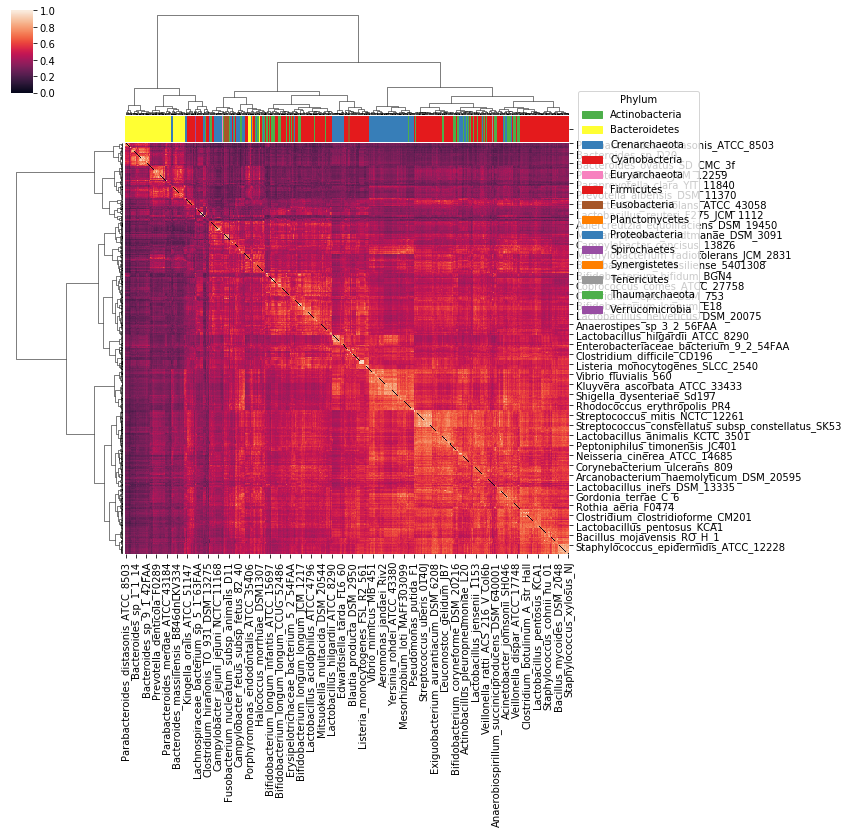

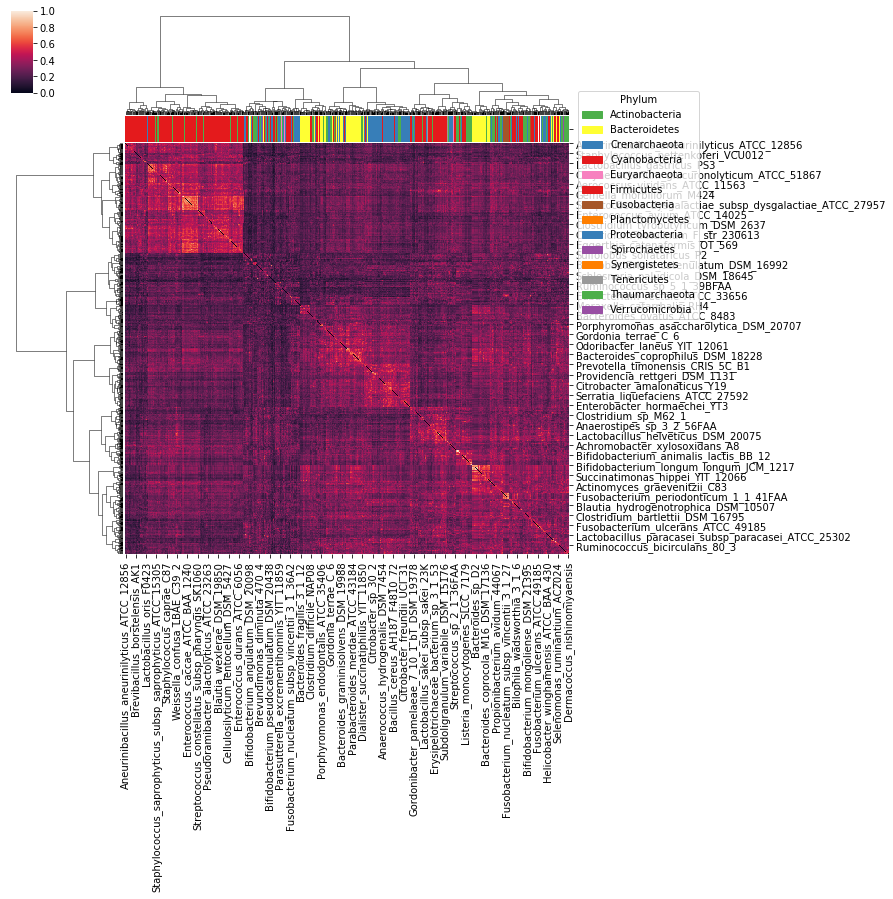

In [165]:
# compute the jaccard index and cluster
# cluster the GO terms based on how similar their annotated proteins are
# use the jaccard index
forced = False
force_plot = True
clustering_method = "ward"
output_prefix = "%s/viz/in-met-%s-" % (out_dir, clustering_method)
in_df = compute_jaccard_and_cluster(species_in_met, output_prefix, method=clustering_method, forced=forced)

#col_colors = []
#species = in_df.index.tolist()
#for s in species:
#    col_colors.append(species_colors[s])
    
# now plot the clustering results
plot_jaccard_overlap(in_df, output_prefix, method=clustering_method, cluster=True, 
                     col_colors=pd.Series(species_colors), label_colors=pd.Series(phylum_colors), forced=force_plot)

output_prefix = "%s/out-met-" % (out_dir)
out_df = compute_jaccard_and_cluster(species_out_met, output_prefix, method=clustering_method, forced=forced)
# now plot the clustering results
plot_jaccard_overlap(out_df, output_prefix, method=clustering_method, cluster=True, 
                     col_colors=pd.Series(species_colors), label_colors=pd.Series(phylum_colors), forced=force_plot)